# CartPole Q-learning

In [16]:
import time
import math
import random
import numpy as np
import gymnasium as gym
from collections import defaultdict
import scipy.stats as stats
import matplotlib.pyplot as plt

### Set up environment

In [17]:
env = gym.make('CartPole-v1')

### Hyperparameters

In [18]:
# PARAMETERS
EPISODES = 350
EPSILON = float
MIN_EPSILON = 0.005
GAMMA = 0.95
LEARNING_RATE = 0.5
MIN_LEARNING_RATE = 0.01
BINS = (1, 1, 6, 3)
SEED = 1

# Set the seed
random.seed(SEED)
np.random.seed(SEED)

N_ACTIONS = env.action_space.n

### Initialize Q-Table

In [19]:
QTABLE = defaultdict(lambda: np.zeros(N_ACTIONS))

### State Discretization

In [20]:
bounds = list(zip(env.observation_space.low, env.observation_space.high))
bounds[1] = (-0.5, 0.5)
bounds[3] = (-math.radians(50), math.radians(50))

def discretize_state(state):
    bin_indices = []
    for i in range(len(state)):
        if state[i] <= bounds[i][0]:
            bin_index = 0
        elif state[i] >= bounds[i][1]:
            bin_index = BINS[i] - 1
        else:
            bound_width = bounds[i][1] - bounds[i][0]
            offset = (BINS[i] - 1) * bounds[i][0] / bound_width
            scale_factor = (BINS[i] - 1) / bound_width
            bin_index = int(round(scale_factor * state[i] - offset))
        bin_indices.append(bin_index)
    return tuple(bin_indices)

### Decay Epsilon

In [21]:
def decay_epsilon(step):
    global EPSILON, MIN_EPSILON
    EPSILON = max(MIN_EPSILON, min(1.0, 1.0 - math.log10((step + 1) / 25)))

### Decay Learning Rate

In [22]:
def decay_learning_rate(step):
    global LEARNING_RATE, MIN_LEARNING_RATE
    LEARNING_RATE =  max(MIN_LEARNING_RATE, min(1.0, 1.0 - math.log10((step + 1) / 25)))

### Action Selection

In [23]:
def select_action(state):
    global EPSILON
    if np.random.random() > EPSILON:
        return int(np.argmax(QTABLE[state]))
    else:
        return random.randint(0, N_ACTIONS - 1)

### Update Q-Table

In [24]:
def update_q_table(state, action, reward, next_state, terminated):
    global LEARNING_RATE, GAMMA, QTABLE
    q_max_next = np.max(QTABLE[next_state])
    if not terminated:
        td_error = reward + GAMMA * q_max_next - QTABLE[state][action]
        QTABLE[state][action] += LEARNING_RATE * td_error
    else:
        td_error = reward - QTABLE[state][action]
        QTABLE[state][action] += LEARNING_RATE * td_error

### Train Q-Learning agent

In [25]:
episode_rewards = np.zeros(EPISODES)
average_reward = []
solved_episode = None

start = time.time()
for episode in range(EPISODES):
    observation, _ = env.reset(seed=SEED)
    state = discretize_state(observation)

    decay_epsilon(episode)
    decay_learning_rate(episode)

    cumulative_reward = 0.0
    done = False
    while not done:
        action = select_action(state)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        next_state = discretize_state(next_obs)
        update_q_table(state, action, reward, next_state, terminated)
        cumulative_reward += reward
        state = next_state
        if terminated or truncated:
            break

    episode_rewards[episode] = cumulative_reward

    if episode >= 100:
        avg_reward = sum(episode_rewards[episode-100:episode]) / 100
        average_reward.append(avg_reward)
        if avg_reward >= 475 and solved_episode is None:
            solved_episode = episode
    else:
        average_reward.append(sum(episode_rewards[:episode]) / 100)

    print(f"Episode: {episode}, Rewards: {cumulative_reward}")
end = time.time()
training_time = end - start

Episode: 0, Rewards: 50.0
Episode: 1, Rewards: 21.0
Episode: 2, Rewards: 19.0
Episode: 3, Rewards: 9.0
Episode: 4, Rewards: 11.0
Episode: 5, Rewards: 24.0
Episode: 6, Rewards: 19.0
Episode: 7, Rewards: 19.0
Episode: 8, Rewards: 28.0
Episode: 9, Rewards: 62.0
Episode: 10, Rewards: 13.0
Episode: 11, Rewards: 9.0
Episode: 12, Rewards: 21.0
Episode: 13, Rewards: 28.0
Episode: 14, Rewards: 13.0
Episode: 15, Rewards: 23.0
Episode: 16, Rewards: 18.0
Episode: 17, Rewards: 25.0
Episode: 18, Rewards: 29.0
Episode: 19, Rewards: 48.0
Episode: 20, Rewards: 9.0
Episode: 21, Rewards: 24.0
Episode: 22, Rewards: 18.0
Episode: 23, Rewards: 19.0
Episode: 24, Rewards: 15.0
Episode: 25, Rewards: 32.0
Episode: 26, Rewards: 12.0
Episode: 27, Rewards: 27.0
Episode: 28, Rewards: 32.0
Episode: 29, Rewards: 10.0
Episode: 30, Rewards: 26.0
Episode: 31, Rewards: 48.0
Episode: 32, Rewards: 14.0
Episode: 33, Rewards: 21.0
Episode: 34, Rewards: 16.0
Episode: 35, Rewards: 13.0
Episode: 36, Rewards: 24.0
Episode: 37, R

### Print Metrics

In [26]:
print(f"Average Reward (last 100): {np.mean(episode_rewards[-100:])}")
print(f"Solved at episode: {solved_episode}")
print(f"Training Time (seconds): {training_time}")

Average Reward (last 100): 500.0
Solved at episode: 286
Training Time (seconds): 4.254951238632202


Text(0, 0.5, 'Reward')

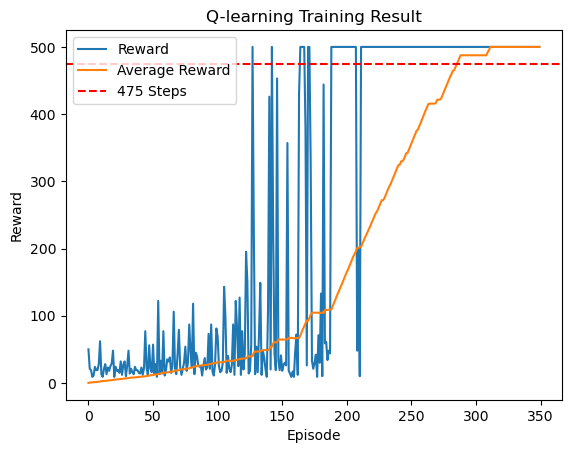

In [27]:
plt.figure()
plt.plot(range(EPISODES), episode_rewards, label = "Reward")
plt.plot(range(EPISODES), average_reward, label = "Average Reward")
plt.axhline(y=475, color='r', linestyle='--', label='475 Steps')
plt.legend(loc='upper left')
plt.title(f"Q-learning Training Result")
plt.xlabel('Episode')
plt.ylabel('Reward')

# Statitistical Analysis

In [28]:
print(f"Mean Reward: {np.mean(episode_rewards)}")
print(f"Median Reward: {np.median(episode_rewards)}")
print(f"Standard Deviation of Rewards: {np.std(episode_rewards)}")

Mean Reward: 266.57714285714286
Median Reward: 223.0
Standard Deviation of Rewards: 230.40129846572884


In [29]:
# Performing a t-test against an expected mean reward 200
t_stat, p_value = stats.ttest_1samp(episode_rewards, 200)
print(f"T-Test statistics: {t_stat}, P-value: {p_value}")

T-Test statistics: 5.398249394948158, P-value: 1.2459266611160817e-07


In [30]:
# Calculating the 95% confidence interval
conf_interval = stats.t.interval(0.95, len(episode_rewards)-1, loc=np.mean(episode_rewards), scale=stats.sem(episode_rewards))
print(f"95% Confidence Interval for Mean Reward: {conf_interval}")

95% Confidence Interval for Mean Reward: (242.32059470380332, 290.8336910104824)
